In [37]:
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pickle
import numpy as np
from nltk.stem import PorterStemmer 
from nltk.lm import Vocabulary
from nltk.tag import StanfordNERTagger, pos_tag
import glob
import contractions
import enchant
import string
import bs4 as bs
import pandas as pd
from collections import Counter
import urllib.request
import re
import multiprocessing
import ndjson
from gensim.models import Word2Vec
import ssl
from google.cloud import storage
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import model_from_json, Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, MaxPooling2D, Conv2D, GlobalAveragePooling2D, Bidirectional, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.metrics import categorical_accuracy
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import backend as K


%load_ext autotime
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

np.random.seed(7)

import warnings
warnings.filterwarnings('ignore')

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import os

device = 'w'

gpath = 'C:/Users/Ani/Desktop/NLP_project/key.json'
ngram_size = 3

if device=='m':
    gpath = '/Users/animallya/Desktop/NLP_project/key.json'

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gpath

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2.0.0
time: 700 ms


In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9149497638173416569
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9046218033475676472
physical_device_desc: "device: XLA_CPU device"
]
time: 1.13 ms


In [18]:
def embed(corpus):
    sentences = nltk.sent_tokenize(' '.join(corpus))
    all_words = [nltk.word_tokenize(sent) for sent in sentences]
    for i in range(len(all_words)):
        all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english') and w not in string.punctuation]
    model = Word2Vec(all_words, min_count=3, workers=multiprocessing.cpu_count())
    return model
#embeddings = embed(corpus)

time: 1.73 ms


In [19]:
import sqlite3
import pandas as pd

def filter_words(text, global_vocab):
    words = []
    for w in text:
        w = w.lower()
        if len(w)>1:
            if global_vocab.check(w)==True:
                words.append(w)
            elif '\'' in w or '’' in w:
                if contractions.fix(w) != w:
                    words.append(contractions.fix(w))
        else:
            if w in['i','a']:
                words.append(w)
    return ' '.join(words)

def message_scrape(path, n):
    
    conn = sqlite3.connect(path)
    c = conn.cursor()
    cmd1 = 'SELECT ROWID, text, handle_id, \
                datetime(date + strftime(\'%s\',\'2001-01-01\'), \'unixepoch\') as date_utc \
                FROM message T1 \
                INNER JOIN chat_message_join T2 \
                    ON T2.chat_id='+str(n)+ ' \
                    AND T1.ROWID=T2.message_id \
                ORDER BY T1.date'
    c.execute(cmd1)
    df_msg = pd.DataFrame(c.fetchall(), columns=['id', 'text', 'sender', 'time'])
    corpus = df_msg.text.tolist()
    corpus = ' '.join(corpus)
    corpus = re.sub('[^a-zA-Z\'\’]', ' ', corpus)
    corpus = re.sub(r'\s+', ' ', corpus)
    corpus = corpus.lower().split(" ")
    filtered_corpus = filter_words(corpus, enchant.Dict("en_US"))
    return filtered_corpus

time: 9.96 ms


## Tf-idf trigram prediction model (continuous Deep Learning)

In [21]:
def preprocess(id, flatten=True):
    
    corpus = message_scrape(path='/Users/animallya/Desktop/chat.db',n=id)
    words = nltk.word_tokenize(corpus)
    Y = [feats.index(words[i]) for i in range(ngram_size, len(words))]
    if flatten == True:
        X = [vectorizer.transform(words[i-ngram_size:i]).toarray().flatten() for i in range(ngram_size, len(words))] 
    else:
        X = [vectorizer.transform(words[i-ngram_size:i]).toarray() for i in range(ngram_size, len(words))]
    Y = [to_categorical(y,len(feats)) for y in Y]
    X, Y = shuffle(X1, y1, random_state=42)
    return np.array(X),np.array(Y), words

time: 1.49 ms


In [20]:
#automate this later
X,y,words = preprocess(2)
words = list(filter(lambda a: a != 'bet', words))
vocab = list(Vocabulary(words))
vectorizer = TfidfVectorizer(vocabulary=vocab)
vectorizer.fit([corpus]) #need multiple documents for later
feats = vectorizer.get_feature_names()

time: 404 ms


In [22]:
sequence_model =  MLPClassifier(n_iter_no_change =2, verbose=1, activation='tanh', learning_rate='constant', alpha=1e-4, random_state=1, warm_start='full') #picked 60 as limit because it overfits after
sequence_model.fit(X,y)

Iteration 1, loss = 821.33243272
Iteration 2, loss = 276.72788402
Iteration 3, loss = 65.89129199
Iteration 4, loss = 31.09132657
Iteration 5, loss = 20.48750289
Iteration 6, loss = 15.67409321
Iteration 7, loss = 13.04754745
Iteration 8, loss = 11.44992845
Iteration 9, loss = 10.40118134
Iteration 10, loss = 9.67870051
Iteration 11, loss = 9.15955379
Iteration 12, loss = 8.77607929
Iteration 13, loss = 8.48380500
Iteration 14, loss = 8.25700039
Iteration 15, loss = 8.07689928
Iteration 16, loss = 7.93223718
Iteration 17, loss = 7.81360767
Iteration 18, loss = 7.71683853
Iteration 19, loss = 7.63532484
Iteration 20, loss = 7.56703437
Iteration 21, loss = 7.50862113
Iteration 22, loss = 7.45878964
Iteration 23, loss = 7.41538630
Iteration 24, loss = 7.37825389
Iteration 25, loss = 7.34546020
Iteration 26, loss = 7.31683707
Iteration 27, loss = 7.29181958
Iteration 28, loss = 7.26906780
Iteration 29, loss = 7.24864186
Iteration 30, loss = 7.23085931
Iteration 31, loss = 7.21430271
Iterat

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=2, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=1, warm_start='full')

time: 3min 34s


In [24]:
def bidirectional_lstm_model():
    print('Build LSTM model.')
    model = Sequential()
    model.add(Bidirectional(LSTM(512, dropout=0.1,
                     recurrent_dropout=0.5,
                     activation="relu",input_shape=(ngram_size, len(vocab))))
    model.add(Dropout(0.5))
    model.add(Dense(len(vocab),activation='softmax'))
    callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
    print("model built!")
    return model

time: 1.48 ms


In [27]:
rnn_model = bidirectional_lstm_model()

Build LSTM model.
model built!
time: 8.15 ms


In [28]:
history_rnn = rnn_model.fit(X, y, batch_size=32, shuffle=True, epochs=20)

Train on 8867 samples
Epoch 1/20
8867/8867 [==============================] - 60s 7ms/sample - loss: 6.2078 - categorical_accuracy: 0.0339
Epoch 2/20
8867/8867 [==============================] - 55s 6ms/sample - loss: 5.8747 - categorical_accuracy: 0.0363
Epoch 3/20
8867/8867 [==============================] - 55s 6ms/sample - loss: 5.7734 - categorical_accuracy: 0.0456
Epoch 4/20
8867/8867 [==============================] - 54s 6ms/sample - loss: 5.6153 - categorical_accuracy: 0.0628
Epoch 5/20
8867/8867 [==============================] - 58s 7ms/sample - loss: 5.3784 - categorical_accuracy: 0.0865
Epoch 6/20
8867/8867 [==============================] - 60s 7ms/sample - loss: 5.1137 - categorical_accuracy: 0.1121
Epoch 7/20
8867/8867 [==============================] - 54s 6ms/sample - loss: 4.8258 - categorical_accuracy: 0.1407
Epoch 8/20
8867/8867 [==============================] - 57s 6ms/sample - loss: 4.5087 - categorical_accuracy: 0.1687
Epoch 9/20
8867/8867 [====================

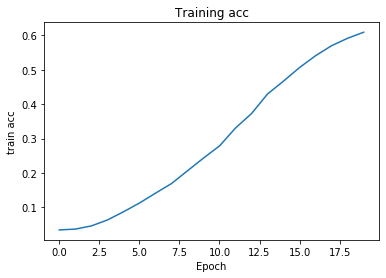

time: 207 ms


In [29]:
#plt.plot(sequence_model.loss_curve_)
plt.plot(history_rnn.history['categorical_accuracy'])
plt.title('Training acc')
plt.ylabel('train acc')
plt.xlabel('Epoch')
plt.show()

In [205]:
def update_model(id, model, flatten=False):
    #corpus = web_scrape(urls)
    corpus = message_scrape(path='/Users/animallya/Desktop/chat.db',n=id)
    words = nltk.wordpunct_tokenize(corpus)
    words = [word for word in words if word in vocab]
    X, y = preprocess(words, flatten=flatten)
    X, y = shuffle(X, y, random_state=42)
    history=None
    if flatten==False:
        history = model.fit(X,y, batch_size=32, shuffle=True, epochs=10)
    else:
        model.fit(X,y)
    print("fit complete")

    return words, history

time: 1.69 ms


In [206]:
#sequence_model, updated_words, = update_model(['Natural_language_processing'], sequence_model, flatten=True)
updated_words, _ = update_model(6, sequence_model, flatten=True)
updated_words, history_update1 = update_model(6, rnn_model)

Iteration 201, loss = 8.20567273
fit complete
Train on 4338 samples, validate on 483 samples
Epoch 1/10
4338/4338 [==============================] - 27s 6ms/sample - loss: 5.9315 - categorical_accuracy: 0.0735 - val_loss: 5.3611 - val_categorical_accuracy: 0.1139
Epoch 2/10
4338/4338 [==============================] - 27s 6ms/sample - loss: 4.9808 - categorical_accuracy: 0.1213 - val_loss: 5.1672 - val_categorical_accuracy: 0.1222
Epoch 3/10
4338/4338 [==============================] - 35s 8ms/sample - loss: 4.6418 - categorical_accuracy: 0.1498 - val_loss: 5.1080 - val_categorical_accuracy: 0.1222
Epoch 4/10
4338/4338 [==============================] - 35s 8ms/sample - loss: 4.3935 - categorical_accuracy: 0.1660 - val_loss: 5.0822 - val_categorical_accuracy: 0.1201
Epoch 5/10
4338/4338 [==============================] - 38s 9ms/sample - loss: 4.1854 - categorical_accuracy: 0.1842 - val_loss: 5.0602 - val_categorical_accuracy: 0.1201
Epoch 6/10
4338/4338 [==============================

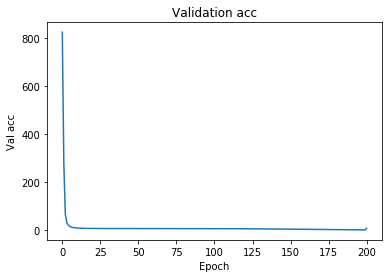

time: 204 ms


In [207]:
plt.plot(sequence_model.loss_curve_)
plt.title('Validation acc')
plt.ylabel('Val acc')
plt.xlabel('Epoch')
plt.show()

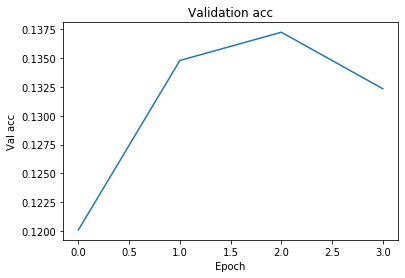

time: 439 ms


In [48]:
plt.plot(history_update1.history['val_categorical_accuracy'])
plt.title('Validation acc')
plt.ylabel('Val acc')
plt.xlabel('Epoch')
plt.show()

## Pos-tagging using trigram max-ent model

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#encoding sets of 3 tags into flattened vector that's one-hot encoded
doc = nlp(corpus)
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

xtemp = [token.tag_ for token in doc]
int_encoded = label_encoder.fit_transform(xtemp)
encoded = onehot_encoder.fit_transform(int_encoded.reshape(len(int_encoded), 1))

X_encoded = []
y_encoded = []

for i in range(ngram_size,len(encoded)):
    x_encoded = encoded[i-ngram_size:i].flatten().astype(int)
    X_encoded.append(x_encoded)
    y_encoded.append(int_encoded[i])
    
y_encoded = np.array(y_encoded)
X_encoded = np.array(X_encoded)

time: 1.54 s


In [41]:
y_encoded.shape

(13096,)

time: 2.73 ms


In [42]:
tag_model = linear_model.LogisticRegression(multi_class='multinomial', class_weight='balanced',solver='saga', penalty = 'l1', n_jobs=-1,verbose=2)
tag_model.fit(X_encoded, y_encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 26 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.8s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', random_state=None, solver='saga', tol=0.0001,
                   verbose=2, warm_start=False)

time: 26.9 s


### Saving all 3 models

In [31]:

def save_model(model, model_name):
    model_json = model.to_json()
    with open("savefiles/"+model_name+".json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("savefiles/"+model_name+"_weights.h5")
    print("Saved model to disk")


#save_model(rnn_model,'rnn_model')

# filename = 'savefiles/wordMLPpredictor.sav'
# pickle.dump(sequence_model, open(filename, 'wb'))

# filename = 'savefiles/postagger.sav'
# pickle.dump(tag_model, open(filename, 'wb'))

# filename = 'savefiles/rnnModel.sav'
# pickle.dump(rnn_model, open(filename, 'wb'))

time: 1.03 ms


# TESTING


In [14]:
def load_model(model_name):
    json_file = open("savefiles/"+model_name+".json")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=[categorical_accuracy])
    # load weights into new model
    model.load_weights("savefiles/"+model_name+"_weights.h5")
    print("Loaded model from disk")
    return model

#rnn_model = load_model('rnn_model')
#sequence_model = pickle.load(open('savefiles/wordMLPpredictor.sav','rb'))
#tag_model = pickle.load(open('savefiles/tagmaxent.sav', 'rb'))

Loaded model from disk
time: 601 ms


In [32]:
def input_tag_to_prediction(inp):
    doc = nlp(inp.lower())
    tags = [token.tag_ for token in doc]
    integer_encoded = label_encoder.transform(tags)
    X_encoded = onehot_encoder.transform(integer_encoded.reshape(len(integer_encoded), 1)).flatten()
    possible_predictions = tag_model.predict_proba(X_encoded.reshape(1, -1))[0]
    indices = (possible_predictions).argsort()[::-1][:3]
    return [label_encoder.inverse_transform([idx])[0] for idx in indices]

time: 2.21 ms


In [33]:
def input_word_to_prediction(inp):
    words = nltk.word_tokenize(inp.lower())
    words_tf = np.array(vectorizer.transform(words).toarray()).flatten().reshape(1, -1)
    possible_predictions = sequence_model.predict_proba(words_tf)[0]
    print(sorted(possible_predictions)[::-1][:3])
    indices = (possible_predictions).argsort()[::-1][:3]
    return [feats[idx] for idx in indices]

time: 1.46 ms


In [34]:
def rnn_predict(sent):
    words = nltk.word_tokenize(sent.lower())
    x = np.array(vectorizer.transform(words).toarray())
    words_tf = x.reshape(1,x.shape[0],x.shape[1])
    y_pred = np.array(rnn_model.predict(words_tf)[0])
    print(sorted(y_pred)[::-1][:3])
    indices = (y_pred).argsort()[::-1][:3]
    return [feats[index] for index in indices]

time: 1.65 ms


In [35]:
def run(sent):
    out = sent
    while True:
        print(out)
        pt = input_tag_to_prediction(sent)
        pw = input_word_to_prediction(sent)
        rw = rnn_predict(sent)
        print(pt)
        print(pw)
        print(rw)
        inp = input()
        if inp=="exit":
            return out
        out+= " " +inp
        l = len(inp.split())
        sent = " ".join(nltk.word_tokenize(sent)[l:]+[inp])
    print(out)

time: 1.89 ms


In [43]:
out = run("i will text")
#i will be home by

i will text
[0.21786836754578953, 0.1386181831777479, 0.12452928878422369]
[0.10975887, 0.09140791, 0.0685784]
['JJS', 'TO', 'PRP']
['you', 'the', 'it']
['it', 'you', 'if']
you
i will text you
[0.09432829422436752, 0.08161868897631654, 0.08115533837439527]
[0.08287811, 0.07939237, 0.050214883]
['MD', 'VBP', 'IN']
['think', 'know', 'are']
['today', 'guys', 'can']
when
i will text you when
[0.09264756872262615, 0.030622383221990238, 0.022683948180986603]
[0.1538603, 0.10666753, 0.09414831]
['PDT', 'PRP$', 'VBP']
['it', 'i', 'you']
['it', 'i', 'you']
i
i will text you when i
[0.35698814097697207, 0.04652795388799914, 0.01916200824464543]
[0.13062379, 0.053329073, 0.04138446]
['VBP', 'VBD', 'MD']
['am', 'is', 'get']
['am', 'get', 'to']
ge
i will text you when i ge
[0.05654717918550446, 0.04397081408634706, 0.030242122032951343]
[0.061992742, 0.013324789, 0.013261226]
['PRP', 'TO', 'IN']
['home', 'end', 'in']
['am', 'text', 'wan']
exit
time: 24.6 s


In [208]:
dev_set = message_scrape(path='/Users/animallya/Desktop/chat.db',n=6)

time: 199 ms


In [213]:
doc = nlp('tomorrow')
print([w.tag_ for w in doc])

['NN']
time: 10.5 ms


In [209]:
dev_set

'hi it is hi i I will text you when i leave at so we can make it there by perfect did i say the star bucks in downtown next to rack and the center cool just clarifying awesome this is on pine st right yeah I am leaving now same liked same eta that is fine are you inside about to be will send you the pictures after class today was nice I am glad you had fun today lets go to on yes let us do it great have you ever seen angel nope is it a movie it is the best movie it is so good movie tickets search mg aw not released yet it is the one wheres the angel here abstract seems interesting we should watch it sometime yes we should if i did not say it today i had fun today liked yes we should you said it thrice yeah i know it was nice i like that we have a funny story about everything that is true I am heading to bed goodnight night good morning good morning how is your day going it is good you are just as lazy as me at no i just got off of work how are you oh was this the only day in the week y

time: 27.6 ms


time: 670 ms


In [153]:
print([w.tag_ for w in doc])
print([w.tag_ for w in pred])

['VBZ', 'DT', 'JJ']
['RB']
time: 964 µs
